<a href="https://colab.research.google.com/github/dercodeKoenig/dqn_trading_gcloudvm/blob/main/evaluate_colab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%writefile kaggle.json
{"username":"bpwqsdd","key":"c01be61298c740525cfe76bfcbe1d233"}

Writing kaggle.json


In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
##################
!pwd
!kaggle datasets download -d bpwqsdd/dqn-trading-v2-1-output
!unzip dqn-trading-v2-1-output.zip
#!kaggle datasets download -d bpwqsdd/dqn-t0-output
#!unzip dqn-t0-output.zip
#!kaggle datasets download -d thetensortoffel/dqn-t0-output-2
#!unzip dqn-t0-output-2.zip
#!kaggle datasets download -d innercirclecat/dqn-t0-output-3
#!unzip dqn-t0-output-3.zip

/content
 82% 9.00M/10.9M [00:01<00:00, 10.3MB/s]
100% 10.9M/10.9M [00:01<00:00, 7.49MB/s]
Archive:  dqn-trading-v2-1-output.zip
  inflating: dqn_training_tpu.py     
  inflating: dqn_weights.h5          
  inflating: evaluate.ipynb          
  inflating: info.txt                
  inflating: loss.txt                
  inflating: make_model.py           
  inflating: manager.py              
  inflating: nohup.out               
  inflating: plot_logs.py            
  inflating: qv.txt                  
  inflating: start.cmd               
  inflating: test.ipynb              
  inflating: utils.py                


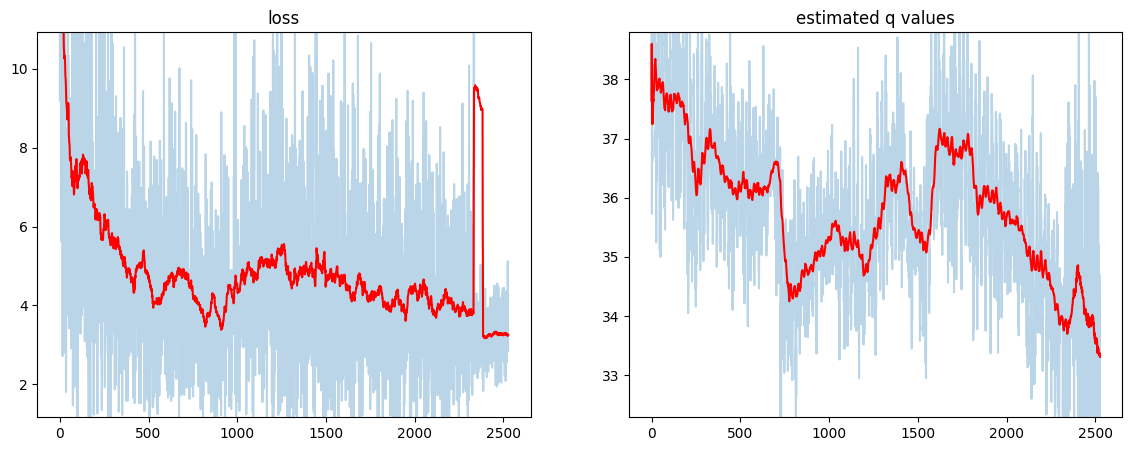

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def get_values(fn):
    f = open(fn)
    lines = f.readlines()
    f.close()

    lines = [float(x.replace("\n","")) for x in lines]
    for i in range(len(lines)):
        if np.isnan(lines[i]):
            lines[i] = 0

    return lines

avg_n=50
k=2

def plot_logs(losses, qs, name):
    fig, ax = plt.subplots(1,2,figsize=(14,5))
    ax[0].set_title("loss")
    lower, upper = np.percentile(losses, [k, 100-k])
    ax[0].set_ylim(lower, upper)
    ax[0].plot(losses, alpha=0.3)
    ax[0].plot([np.mean(losses[max(0,i-avg_n):i+1]) for i in range(len(losses))], c="r")
    ax[1].set_title("estimated q values")
    lower, upper = np.percentile(qs, [k, 100-k])
    ax[1].set_ylim(lower, upper)
    ax[1].plot(qs, alpha=0.3)
    ax[1].axhline(0)
    ax[1].plot([np.mean(qs[max(0,i-avg_n):i+1]) for i in range(len(qs))], c="r")
    plt.savefig(name)

try:
	losses = get_values("loss.txt")
	qs = get_values("qv.txt")
	plot_logs(losses, qs, "t1.jpg")
except:pass

In [ ]:
!rm info.txt
!kaggle datasets download -d bpwqsdd/us-index-cfd-data
!mkdir data
!unzip us-index-cfd-data.zip
!mv *.o data/

100% 1.18G/1.18G [00:58<00:00, 21.8MB/s]
100% 1.18G/1.18G [00:58<00:00, 21.6MB/s]
Archive:  us-index-cfd-data.zip
  inflating: ENQ_1.csv               
  inflating: ENQ_1.o                 
  inflating: ENQ_1_inverted.o        
  inflating: EP_1.csv                
  inflating: EP_1.o                  
  inflating: EP_1_inverted.o         
  inflating: US30_1.csv              
  inflating: US30_1.o                
  inflating: US30_1_inverted.o       
  inflating: US500_1.csv             
  inflating: US500_1.o               
  inflating: US500_1_inverted.o      
  inflating: USTEC_1.csv             
  inflating: USTEC_1.o               
  inflating: USTEC_1_inverted.o      
  inflating: YM_1.csv                
  inflating: YM_1.o                  
  inflating: YM_1_inverted.o         
  inflating: info.txt                
  inflating: parts_ENQ_1.o/part_000  
  inflating: parts_ENQ_1.o/part_001  
  inflating: parts_ENQ_1.o/part_002  
  inflating: parts_ENQ_1.o/part_003  
  inflating:

In [ ]:
#!cp dqn_trading_gcloudvm/t1/dqn_weights.h5 .
#!cp dqn_trading_gcloudvm/t1/manager.py .
#!cp dqn_trading_gcloudvm/t1/make_model.py .
#!cp dqn_trading_gcloudvm/t1/utils.py .

In [ ]:
from manager import *
from utils import *
from make_model import *

import tensorflow as tf
import time
from manager import candle_class
import random
import numpy as np
from collections import deque
import time
import os

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
path2 = "US500_1.o"
path1 = "USTEC_1.o"
cm = 3

In [ ]:

class match_time_cor_market:
    def __init__ (self,path):
        self.path = path
        self.candle_index = 0
        self.candles = Load(self.path)
        self.last_candle = candle_class(0,0,0,0,[1,1,2000,0,0,0])
        self.time_int2 = 0

    def get_next_candle(self):
        if self.candle_index >= len(self.candles):
          print("error - no more candles")
          return -1

        self.last_candle = self.candles[self.candle_index]
        self.candle_index+=1
        return 0


    def get_candle_by_time_match(self, t):
        t = t.split(":")
        t = [int(x) for x in t]
        time_int1 = (t[0] + t[1]*31+t[2]*366) * 24 * 60 + t[3]*60 + t[4]



        while self.time_int2 < time_int1:
            if self.get_next_candle() == 0:
                t = self.last_candle.t
                t = t.split(":")
                t = [int(x) for x in t]
                self.time_int2 = (t[0] + t[1]*31+t[2]*366) * 24 * 60 + t[3]*60 + t[4]
            else:
                return -1

        #print(time_int1, self.time_int2)

        if self.time_int2 == time_int1:
            return self.last_candle
        if self.time_int2 > time_int1:
            #print("candle data missing - skip candle")
            return self.last_candle


In [ ]:
data_dir = "data/"
path1 = data_dir+path1
path2 = data_dir+path2

start = 1760000

In [ ]:
model = make_model()
model.load_weights("dqn_weights.h5")

In [ ]:

candle_counter = -1
last_state = 0

x = manager()
x2 = manager()

c_match_system = match_time_cor_market(path2)

position = 0
balance = 0
equity_list = []
balances = []
vol = 1

outputs = []
candle_position_history = []

entry_price = -1
reset_entry_price = False


def close(c):
    global balance, position, entry_price
    balance += (c - entry_price) * vol * position
    balance -= cm / 2 * vol
    position = 0
    entry_price = -1


sample_counter = 0

candles = Load(path1)
for i in range(0, len(candles)):
                candle_counter+=1

                candle2 = c_match_system.get_candle_by_time_match(candles[i].t)
                if candle2 == -1:
                    print("secondary data file ended - break")
                    break

                ret2 = x2.push_m1_candle(candle2)
                ret = x.push_m1_candle(candles[i])

                if candle_counter>=start:

                    #disable relative scaling
                    #ret[0][1] = 1
                    #########

                    inp = get_inputs_from_ret(ret, x)
                    inp2 = get_inputs_from_ret(ret2, x2)
                    inp2 = [inp2[0]] + [inp2[3]] + [inp2[4]] + [inp2[5]]

                    new_state = [position]+inp+inp2


                    m_input = [np.expand_dims(new_state[i], axis=0) for i in range(len(new_state))]
                    o = model(m_input) # scores: short, long, neutral
                    o = o.numpy().tolist()[0]
                    #o[2] = -999
                    action = np.argmax(o)


                    if reset_entry_price:
                        entry_price = x.m1_candles[-1].o
                        reset_entry_price = False

                    candle_position_history.append([x.m1_candles[-1], position])




                    c = x.m1_candles[-1].c
                    open_profit = position * vol * (c - entry_price)

                    if action == 0: # short
                        if position != -1:
                            close(c)
                            position = -1
                            balance -= cm / 2 * vol
                            reset_entry_price = True

                    if action == 1: # long
                        if position != 1:
                            close(c)
                            position = 1
                            balance -= cm / 2 * vol
                            reset_entry_price = True

                    if action == 2: # neutral
                        if position != 0:
                            close(c)

                    balances.append(balance)


                    equity = balance + open_profit
                    equity_list.append(equity)

                    #print([ round(i,2) for i in  o.numpy().flatten().tolist() ], position, balance, equity)
                    sample_counter+=1
                    if sample_counter % 100 == 0:
                        print(sample_counter, position, equity)

                    outputs.append(o)

                    if sample_counter >= 23*60*5*4*3:
                        break

In [ ]:
x.m1_candles[-1].t, x2.m1_candles[-1].t,len(candles), candles[-1].t

([31, 1, 2024, 19, 44, 2],
 [31, 1, 2024, 19, 44, 2],
 1864511,
 '19:4:2024:16:56:4')

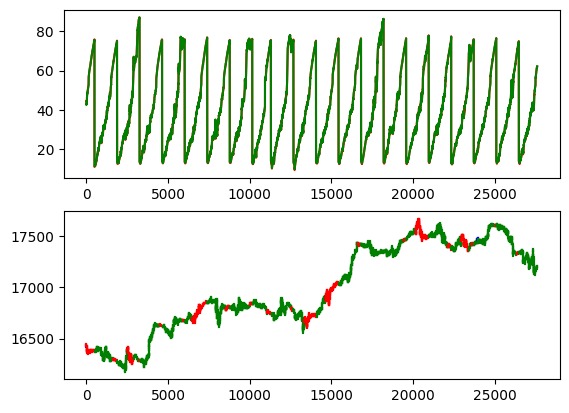

In [ ]:
import matplotlib.pyplot as plt
short_predictions = [x[0] for x in outputs]
long_predictions = [x[1] for x in outputs]
neutral_predictions = [x[2] for x in outputs]


_, ax = plt.subplots(2,1)
ax[0].plot(short_predictions, c="r")
ax[0].plot(long_predictions, c="g")
#ax[0].plot(neutral_predictions, c="b")


for index,i in enumerate(candle_position_history):
    o = i[0].o
    c = i[0].c
    if i[1] == -1:
        color = "r"
    if i[1] == 1:
        color = "g"
    if i[1] == 0:
        color = "b"
    ax[1].plot([index,index],[o,c],c=color)

In [ ]:
x.m1_candles[-1].t

[31, 1, 2024, 19, 44, 2]

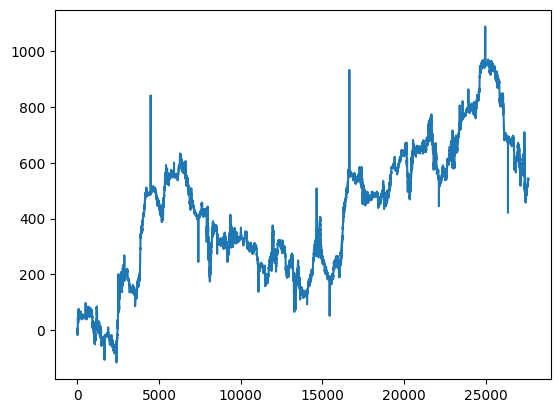

In [ ]:
plt.plot(equity_list)

In [ ]:
equity_list

[-0.9,
 -3.109999999999127,
 -0.15000000000000002,
 2.7500000000014553,
 -2.730000000001746,
 -11.96000000000131,
 -18.240000000000144,
 -17.96000000000131,
 -13.309999999999855,
 -6.469999999999709,
 -10.949999999999273,
 -11.440000000000873,
 2.5700000000011642,
 6.390000000000873,
 1.379999999998836,
 7.269999999998253,
 3.0799999999995635,
 4.030000000000291,
 6.820000000001164,
 5.430000000001746,
 5.890000000000873,
 8.070000000001164,
 12.710000000000582,
 10.940000000000145,
 25.780000000000292,
 13.03000000000029,
 22.8599999999984,
 24.55000000000073,
 26.1099999999984,
 29.870000000000438,
 36.009999999999856,
 45.80999999999913,
 38.87000000000044,
 33.21000000000058,
 35.18000000000175,
 39.00000000000146,
 39.8599999999984,
 38.640000000000875,
 44.28999999999869,
 40.3400000000016,
 48.329999999999565,
 43.78000000000029,
 46.23000000000102,
 49.91999999999971,
 46.44000000000015,
 38.320000000001166,
 37.62000000000044,
 50.79000000000051,
 53.33999999999978,
 52.069999

In [ ]:
model(m_input)

for i in range(len(model.layers)):
  tm = tf.keras.Model(inputs = model.inputs, outputs=model.layers[i].output)
  out = tm(m_input)

  print(model.layers[i].name)
  print(out)


input_6
tf.Tensor([[2.]], shape=(1, 1), dtype=float32)
embedding
tf.Tensor([[[0.006393 0.01886  0.02682 ]]], shape=(1, 1, 3), dtype=float16)
input_5
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
input_4
tf.Tensor([[-4.0146084]], shape=(1, 1), dtype=float32)
input_7
tf.Tensor([[1184.]], shape=(1, 1), dtype=float32)
flatten
tf.Tensor([[0.006393 0.01886  0.02682 ]], shape=(1, 3), dtype=float16)
input_8
tf.Tensor([[-7.515187]], shape=(1, 1), dtype=float32)
concatenate
tf.Tensor([[ 1.000e+00 -4.016e+00  1.184e+03  6.393e-03  1.886e-02  2.682e-02]], shape=(1, 6), dtype=float16)
concatenate_9
tf.Tensor([[-7.516e+00  1.184e+03  6.393e-03  1.886e-02  2.682e-02]], shape=(1, 5), dtype=float16)
dense
tf.Tensor(
[[ 69.6   212.4   122.75    0.      0.     54.9   119.2    83.56  205.9
    0.     95.44    0.      0.      0.     60.03    0.    162.5     0.
  157.8   133.9     0.      0.      0.    143.6   176.    206.8   117.25
  121.9     0.      0.      0.      0.      0.      0.      0.      0.
   